In [36]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys
# 確保 models 資料夾的路徑正確
models_path = os.path.abspath("../models")
if models_path not in sys.path:
    sys.path.append(models_path)

# 引入 HDDM 和 GRU 模型
from hddm_model import HDDM
from gru_model import GRUModel  # 假設您已經撰寫好 GRU 模型

In [43]:
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import os
import random
from collections import Counter

class AugmentedVideoROIDataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentation_count=5):
        """
        初始化 Video ROI Dataset 並對 "Real" 類別進行數據增強
        :param root_dir: 根資料夾，包括 real 和 fake
        :param transform: 圖像的 transform
        :param augmentation_count: 對每張 "Real" 類別影像增強的次數
        """
        self.root_dir = root_dir
        self.transform = transform
        self.augmentation_count = augmentation_count
        self.data = []
        self.labels = []

        # 加載資料
        for label, subdir in enumerate(["real", "fake"]):
            subdir_path = os.path.join(root_dir, subdir, "full_face")
            if not os.path.exists(subdir_path):
                print(f"Directory does not exist: {subdir_path}")
                continue

            for file_name in os.listdir(subdir_path):
                if file_name.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(subdir_path, file_name)
                    self.data.append(img_path)
                    self.labels.append(label)

                    # 若為 "Real" 類別，進行數據增強
                    if label == 0:  # Real 類別標籤為 0
                        augmented_images = self.augment_image(img_path)
                        self.data.extend(augmented_images)
                        self.labels.extend([label] * len(augmented_images))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path_or_image = self.data[idx]
        label = self.labels[idx]

        # 如果是文件路徑，則加載圖片，否則直接使用內存中的圖片
        if isinstance(img_path_or_image, str):
            image = Image.open(img_path_or_image).convert("RGB")
        else:
            image = img_path_or_image

        # 應用轉換
        if self.transform:
            image = self.transform(image)

        return image, label

    def augment_image(self, img_path):
        """
        對指定影像進行數據增強
        :param img_path: 影像路徑
        :return: 增強後影像的列表
        """
        augmented_images = []
        image = Image.open(img_path).convert("RGB")

        for _ in range(self.augmentation_count):
            # 隨機旋轉
            rotated = F.rotate(image, angle=random.uniform(-30, 30))

            # 隨機水平翻轉
            if random.random() > 0.5:
                rotated = F.hflip(rotated)

            # 隨機調整亮度
            brightness = F.adjust_brightness(rotated, brightness_factor=random.uniform(0.8, 1.2))

            # 保存增強影像到內存（僅在內存中保存）
            augmented_images.append(brightness)

        return augmented_images


# 資料準備
data_root = "../HDDM_Project/data_video"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# 初始化數據集
dataset = AugmentedVideoROIDataset(root_dir=data_root, transform=transform, augmentation_count=100)

# 訓練集和測試集的分割比例
train_ratio = 0.8
test_ratio = 1 - train_ratio

# 計算訓練集與測試集的大小
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# 使用 random_split 分割數據集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 創建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 打印數據集大小
print(f"Total dataset size: {len(dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# 獲取標籤分佈
def get_label_distribution(dataset):
    """
    獲取數據集中標籤的分佈
    :param dataset: Dataset 對象
    :return: 標籤分佈的 Counter
    """
    labels = []
    for _, label in dataset:
        labels.append(label)
    return Counter(labels)

# 打印測試集標籤分佈
test_label_distribution = get_label_distribution(test_dataset)
print(f"Test dataset label distribution: {test_label_distribution}")

# 打印訓練集標籤分佈
train_label_distribution = get_label_distribution(train_dataset)
print(f"Train dataset label distribution: {train_label_distribution}")


Total dataset size: 8281
Training dataset size: 6624
Testing dataset size: 1657
Test dataset label distribution: Counter({1: 996, 0: 661})
Train dataset label distribution: Counter({1: 4053, 0: 2571})


In [44]:
# !pip3 install torch torchvision torchaudio

In [45]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

print(device)

mps


In [46]:
# 模型初始化：支持分別控制 HDDM 和 GRU 的微調
def initialize_models(fine_tune_hddm=False, fine_tune_gru=False, hddm_path=None, gru_path=None):
    """
    初始化 HDDM 和 GRU 模型
    :param fine_tune_hddm: 是否微調 HDDM
    :param fine_tune_gru: 是否微調 GRU
    :param hddm_path: HDDM 預訓練模型的路徑（若有）
    :param gru_path: GRU 預訓練模型的路徑（若有）
    """
    # 初始化 HDDM 模型
    hddm_model = HDDM().to(device)
    if fine_tune_hddm and hddm_path:
        print(f"Loading pre-trained HDDM model from {hddm_path}...")
        hddm_model.load_state_dict(torch.load(hddm_path, map_location=device))
        print("HDDM model loaded successfully.")
    else:
        print("HDDM model will be trained from scratch.")

    # 初始化 GRU 模型
    gru_model = GRUModel(input_size=512, hidden_size=128, num_layers=2, num_classes=2).to(device)
    if fine_tune_gru and gru_path:
        print(f"Loading pre-trained GRU model from {gru_path}...")
        gru_model.load_state_dict(torch.load(gru_path, map_location=device))
        print("GRU model loaded successfully.")
    else:
        print("GRU model will be trained from scratch.")

    return hddm_model, gru_model


# 選項設置
fine_tune_hddm = True  # 是否微調 HDDM
fine_tune_gru = False  # 是否微調 GRU

hddm_pretrained_path = "../models/hddm_model_1.pth" if fine_tune_hddm else None
gru_pretrained_path = "../models/gru_model.pth" if fine_tune_gru else None

# 初始化模型
hddm_model, gru_model = initialize_models(
    fine_tune_hddm=fine_tune_hddm,
    fine_tune_gru=fine_tune_gru,
    hddm_path=hddm_pretrained_path,
    gru_path=gru_pretrained_path
)


Loading pre-trained HDDM model from ../models/hddm_model_1.pth...


/var/folders/4f/qpcc_31940v5l8s4q4qv11180000gn/T/ipykernel_53668/1893190950.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hddm_model.load_state_dict(torch.load(hddm_p

HDDM model loaded successfully.
GRU model will be trained from scratch.


In [47]:
# 定義損失函數
criterion = nn.CrossEntropyLoss() ## Ref. https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# 定義不同情境的學習率
hddm_lr = 1e-4 if fine_tune_hddm else 1e-3  # 微調時學習率較低
gru_lr = 1e-4 if fine_tune_gru else 1e-3    # 微調時學習率較低

# 定義優化器
optimizer = torch.optim.Adam([                           # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    {"params": hddm_model.parameters(), "lr": hddm_lr},  # HDDM 模型的學習率
    {"params": gru_model.parameters(), "lr": gru_lr},    # GRU 模型的學習率
])


In [48]:
# 定義特徵適配層
class FeatureAdapter(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeatureAdapter, self).__init__()
        self.fc = nn.Linear(input_size, output_size)  # 將 HDDM 的輸出映射到 GRU 的輸入尺寸

    def forward(self, x):
        return self.fc(x)  # 返回適配後的特徵


In [49]:
# 初始化 HDDM、GRU 和特徵適配層
feature_adapter = FeatureAdapter(input_size=2, output_size=128).to(device)  # 將 HDDM 的 2 維輸出轉換為 128 維
gru_model = GRUModel(input_size=128, hidden_size=128, num_layers=2, num_classes=2).to(device)

Epoch [1/10] - Training Loss: 0.6543, Training Accuracy: 0.8392
Epoch [1/10] - Test Loss: 0.6087, Test Accuracy: 0.9366
Epoch [2/10] - Training Loss: 0.5961, Training Accuracy: 0.9503
Epoch [2/10] - Test Loss: 0.5920, Test Accuracy: 0.9614
Epoch [3/10] - Training Loss: 0.5834, Training Accuracy: 0.9644
Epoch [3/10] - Test Loss: 0.5815, Test Accuracy: 0.9590
Epoch [4/10] - Training Loss: 0.5777, Training Accuracy: 0.9692
Epoch [4/10] - Test Loss: 0.5771, Test Accuracy: 0.9686
Epoch [5/10] - Training Loss: 0.5746, Training Accuracy: 0.9716
Epoch [5/10] - Test Loss: 0.5749, Test Accuracy: 0.9734
Epoch [6/10] - Training Loss: 0.5723, Training Accuracy: 0.9736
Epoch [6/10] - Test Loss: 0.5734, Test Accuracy: 0.9698
Epoch [7/10] - Training Loss: 0.5707, Training Accuracy: 0.9787
Epoch [7/10] - Test Loss: 0.5716, Test Accuracy: 0.9777
Epoch [8/10] - Training Loss: 0.5696, Training Accuracy: 0.9790
Epoch [8/10] - Test Loss: 0.5709, Test Accuracy: 0.9753
Epoch [9/10] - Training Loss: 0.5689, Tr

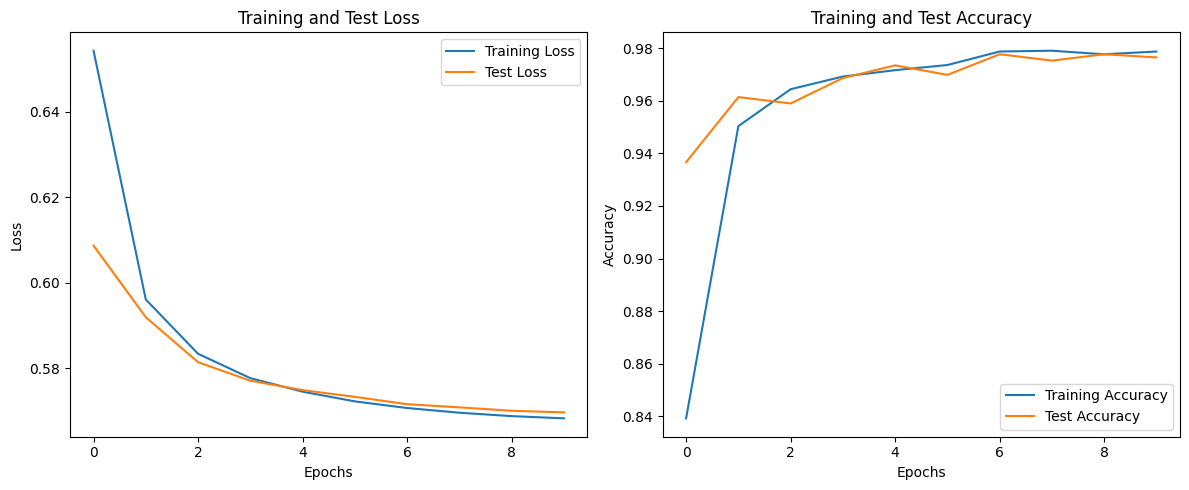

In [50]:
import matplotlib.pyplot as plt

# 訓練模型並記錄訓練和測試損失與準確率
def train_and_evaluate(hddm_model, gru_model, train_loader, test_loader, criterion, optimizer, epochs=10):
    hddm_model.train()
    gru_model.train()
    
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # 訓練階段
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # HDDM 提取特徵
            features = hddm_model(images)
            features = feature_adapter(features)

            # GRU 預測
            outputs = gru_model(features.unsqueeze(1))

            # 計算損失
            loss = criterion(outputs, labels)

            # 反向傳播與優化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 計算準確率
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 記錄訓練損失與準確率
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

        # 測試階段
        hddm_model.eval()
        gru_model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                # HDDM 提取特徵
                features = hddm_model(images)
                features = feature_adapter(features)

                # GRU 預測
                outputs = gru_model(features.unsqueeze(1))

                # 計算損失
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()

                # 計算準確率
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        # 記錄測試損失與準確率
        test_epoch_loss = test_running_loss / len(test_loader)
        test_epoch_acc = test_correct / test_total
        test_loss_history.append(test_epoch_loss)
        test_acc_history.append(test_epoch_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_acc:.4f}")

        # 切回訓練模式
        hddm_model.train()
        gru_model.train()

    return train_loss_history, train_acc_history, test_loss_history, test_acc_history

# 訓練並記錄數據
train_loss, train_acc, test_loss, test_acc = train_and_evaluate(
    hddm_model, gru_model, train_loader, test_loader, criterion, optimizer, epochs=10
)

# 繪製訓練與測試歷史記錄
plt.figure(figsize=(12, 5))

# 繪製損失圖
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

# 繪製準確率圖
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Confusion matrix saved to confusion_matrix.png


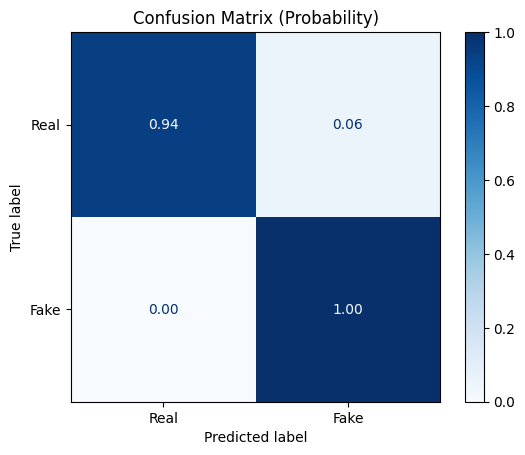


Classification Report:
              precision    recall  f1-score   support

        Real       1.00      0.94      0.97       661
        Fake       0.96      1.00      0.98       996

    accuracy                           0.98      1657
   macro avg       0.98      0.97      0.98      1657
weighted avg       0.98      0.98      0.98      1657



In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_and_plot_confusion_matrix(hddm_model, gru_model, test_loader, save_fig=False, fig_path="confusion_matrix.png"):
    """
    評估模型並生成混淆矩陣
    :param hddm_model: 預訓練的 HDDM 模型
    :param gru_model: 預訓練的 GRU 模型
    :param test_loader: 測試數據加載器
    :param save_fig: 是否保存混淆矩陣圖片
    :param fig_path: 混淆矩陣保存路徑
    """
    hddm_model.eval()
    gru_model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # HDDM 提取特徵
            features = hddm_model(images)
            features = feature_adapter(features)

            # GRU 預測
            outputs = gru_model(features.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # 計算混淆矩陣
    cm = confusion_matrix(all_labels, all_preds, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title("Confusion Matrix (Probability)")
    if save_fig:
        plt.savefig(fig_path)
        print(f"Confusion matrix saved to {fig_path}")
    plt.show()

    # 打印分類報告
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))

# 調用評估函數
evaluate_and_plot_confusion_matrix(
    hddm_model, gru_model, test_loader, save_fig=True, fig_path="confusion_matrix.png"
)
